### 1. Importing Dependency

In [29]:
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout,TextVectorization

import warnings
warnings.filterwarnings("ignore")

### 2. Loading Dataset

In [30]:
## using pandas read_csv funtion to load csv files
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
# sample_submission  = pd.read_csv('Data/sample_submission.csv')

### 3. Data processing

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:

test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
print(f"test shape {test.shape}")
print(f"train shape {train.shape}")

test shape (3263, 4)
train shape (7613, 5)


In [6]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [31]:
train.target.value_counts()
# 0 - not a disaster
# 1 - disaster

0    4342
1    3271
Name: target, dtype: int64

<AxesSubplot: xlabel='count', ylabel='target'>

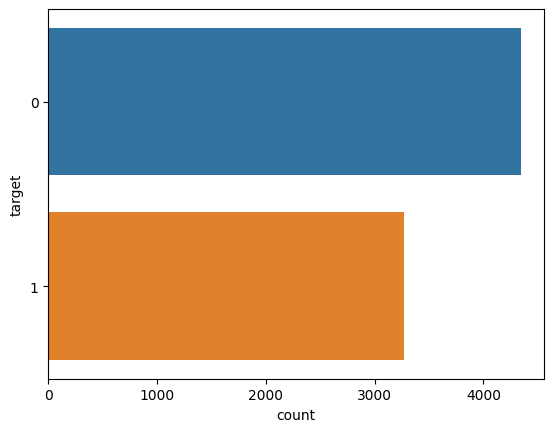

In [9]:
sns.countplot(y=train.target)

### 4. Data cleaning

In [10]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [32]:
train.location.value_counts().to_frame()

,location
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
"MontrÌ©al, QuÌ©bec",1
Montreal,1
"ÌÏT: 6.4682,3.18287",1
Live4Heed??,1


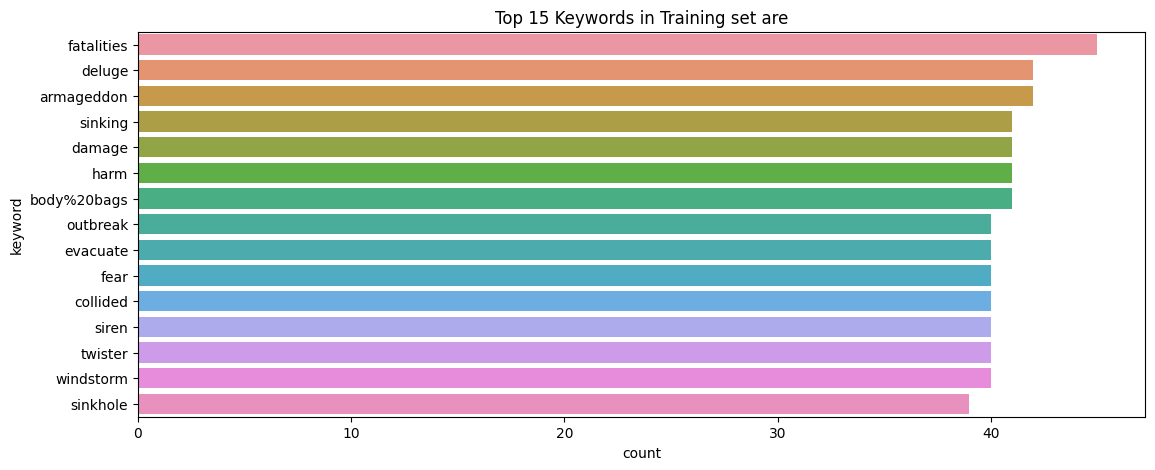

In [13]:
# finding most common keywords
plt.figure(figsize=(13, 5))
# print(train.keyword.value_counts().iloc[:15].index)
# print(train.keyword)
sns.countplot(y=train.keyword, order=train.keyword.value_counts().iloc[:15].index)
plt.title("Top 15 Keywords in Training set are")
plt.show()

In [14]:
print(train['text'].head())

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object


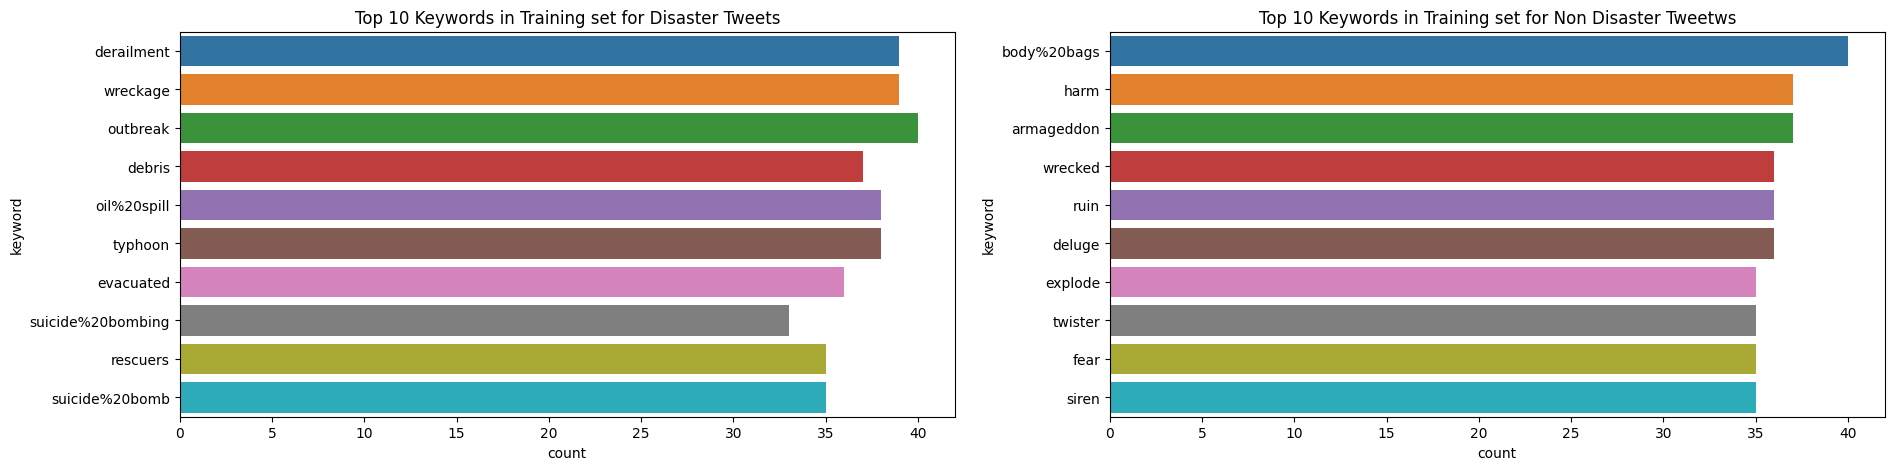

In [15]:
# finding most common keywords
plt.figure(figsize=(22, 5))
plt.subplot(121)
sns.countplot(y=train.keyword, order=train[train.target == 1].keyword.value_counts().iloc[:10].index)
plt.title("Top 10 Keywords in Training set for Disaster Tweets")
plt.subplot(122)
sns.countplot(y=train[train.target == 0].keyword, order=train[train.target == 0].keyword.value_counts().iloc[:10].index)
plt.title("Top 10 Keywords in Training set for Non Disaster Tweetws")
plt.show()

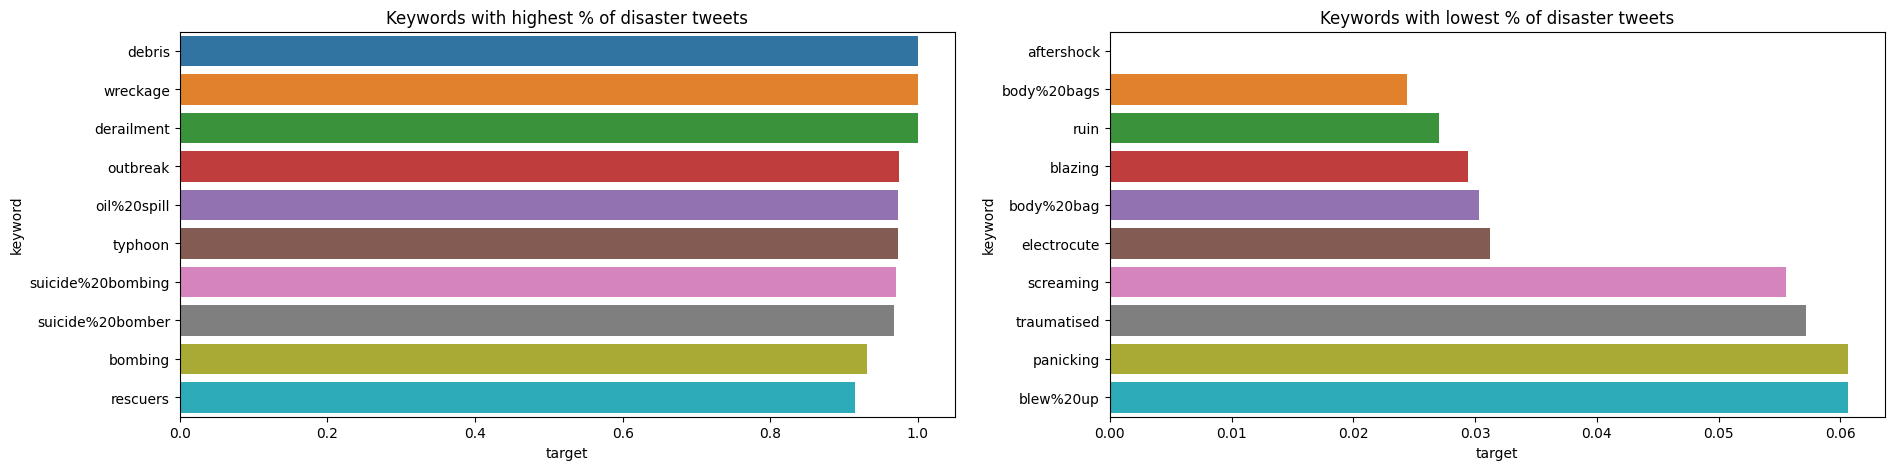

In [16]:
top_d = train.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = train.groupby('keyword').mean()['target'].sort_values().head(10)

# top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
# plt.figure(figsize=(14, 6))
# sns.barplot(x=top_l.index, y=top_l)
# plt.axhline(np.mean(train.target))
# plt.xticks(rotation=80)
# plt.show()

plt.figure(figsize=(22,5))
plt.subplot(121)
sns.barplot(x= top_d,y=top_d.index)
plt.title('Keywords with highest % of disaster tweets')
plt.subplot(122)
sns.barplot(x=top_nd, y=top_nd.index)
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

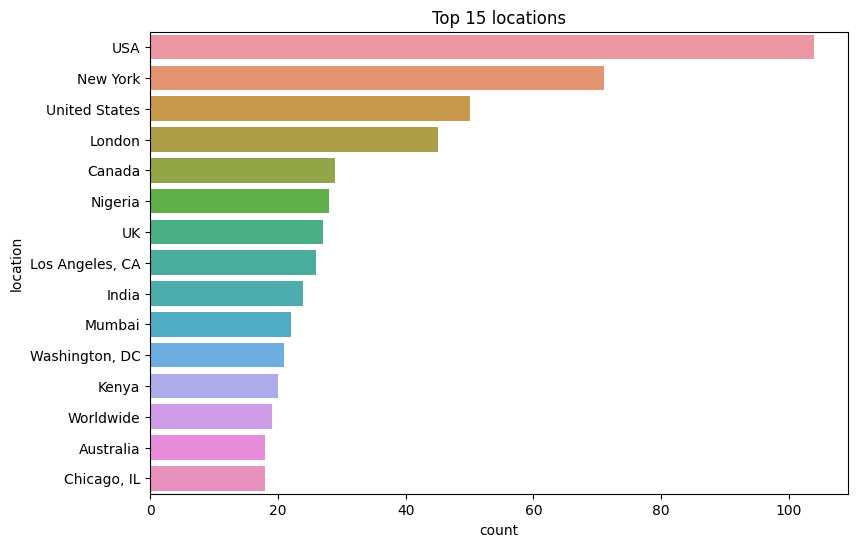

In [17]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

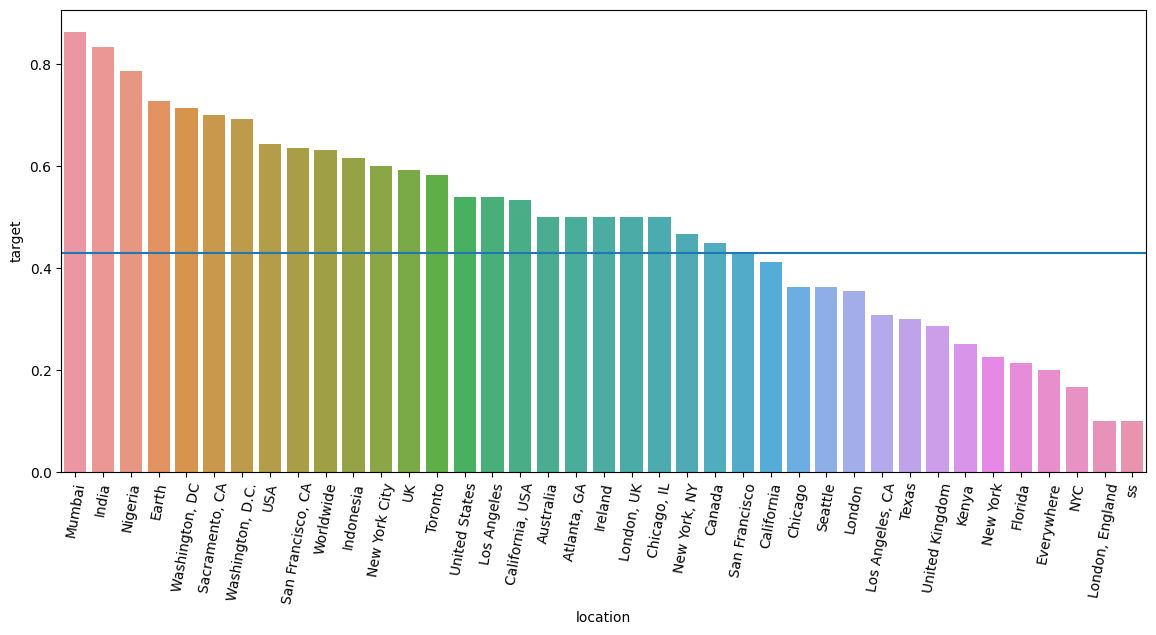

In [18]:
raw_loc = train.location.value_counts()
# print(raw_loc)
top_loc = list(raw_loc[raw_loc>=10].index)
# print(top_loc)
top_only = train[train.location.isin(top_loc)]
# top_only
top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14, 6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

In [33]:
# fill na values
for col in ["keyword", "location"]:
    train[col] = train[col].fillna("None")
    test[col] = test[col].fillna("None")
raw_loc = train.location.value_counts()
# print(raw_loc)
top_loc = list(raw_loc[raw_loc>=10].index)

def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'
    
train['location'] = train['location'].apply(lambda x: clean_loc(str(x)))
test['location'] = test['location'].apply(lambda x: clean_loc(str(x)))

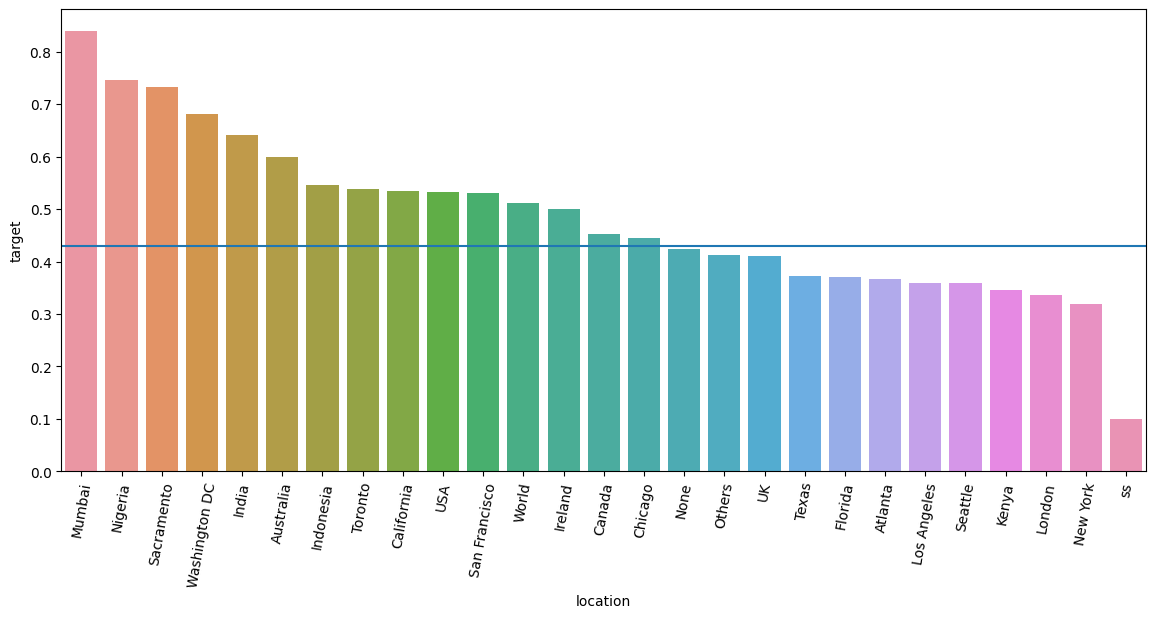

In [20]:
top_l2 = train.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l2.index, y=top_l2)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

In [34]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    'hwy': 'highway',
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    'w/e': 'whatever',
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

# Change an abbreviation to its true word
def fix_abbrev(text):
    return ' '.join([abbreviations[word.lower()] if (word.lower() in abbreviations.keys()) else word for word in text.split()])

# Replace some others smiley face with SADFACE
def transcription_sad(text):
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'sad', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'love', text)

# Replace URLs
def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# Remove HTML
def remove_html(text):
    return re.sub(r'<.*?>', '', text)

# Converts text to lowercase
def to_lower(text):
    return text.lower()

# Remove words contaning numbers
def remove_numbers(text):
    return re.sub(r'\w*\d\w*', '', text)

# Remove text in brackets
def remove_brackets(text):
    return re.sub(r'\[.*?\]', '', text)  

# Replace mentions
def remove_mentions(text):
    return re.sub(r'@\w*', '', text)

# Remove hashtags
def remove_hashtags(text):
    return re.sub(r'#\w*', '', text)

# Remove emojis
def remove_emojis(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
    "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

# Remove non-ASCII characters
def remove_non_ascii(text):
#     return ''.join(filter(lambda x: x in string.printable, text))
    return text.encode("ascii",errors="ignore").decode()

# Remove stopwords
def remove_stopwords(text):
    return ' '.join([token.text for token in nlp(text) if not token.is_stop])

# Remove punctuation
def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Remove white space (Extra step, just in case)
def remove_whitespace(text):
    return ' '.join(text.split())

# Filter out words with too few characters (2 by default)
def filter_words(text):
    return ' '.join([word for word in text.split() if len(word) > 2])

In [35]:
for df in [train, test]:
    
    text = df['text']
    
    # Convert to lowercase
    text = text.apply(to_lower)

    # Replace symbols
    text = text.replace(r'&amp;?', r'and')
    text = text.replace(r'&lt;', r'<')
    text = text.replace(r'&gt;', r'>')
    text = text.replace('&amp;', " and ")
    
    # Manual Lemmatize
    text = text.str.replace('won\'t', 'will not')
    text = text.str.replace('can\'t', 'cannot')
    text = text.str.replace('i\'m', 'i am')
    text = text.replace('ain\'t', 'is not')
    
    # Remove mentions and links (hashtags too?)
#     text = text.apply(remove_hashtags)
    text = text.apply(remove_mentions)
    text = text.apply(remove_urls)

    # Fix abbreviations
    text = text.apply(fix_abbrev)
    
    # Remove HTML tags
    text = text.apply(remove_html)
    

    # Fix emojies
    text = text.apply(transcription_sad)   # Sad emojies
    text = text.apply(transcription_heart) # Heart emoji
    text = text.apply(remove_emojis)       # General emojies

    # Remove non-ASCII characters
    text = text.apply(remove_non_ascii)
    
    # Remove words contaning numbers
    text = text.apply(remove_numbers)
    
    # Remove punctuations
    text = text.apply(remove_punctuation)

    
    # Fill entry if turns out empty
    text = text.apply(lambda x: x if x != '' else '?')

    df['text'] = text

In [36]:
from nltk import FreqDist, word_tokenize
from wordcloud import STOPWORDS

# Make a set of stop words
stopwords = set(STOPWORDS)
# more_stopwords = {'https', 'amp'}
# stopwords = stopwords.union(more_stopwords)

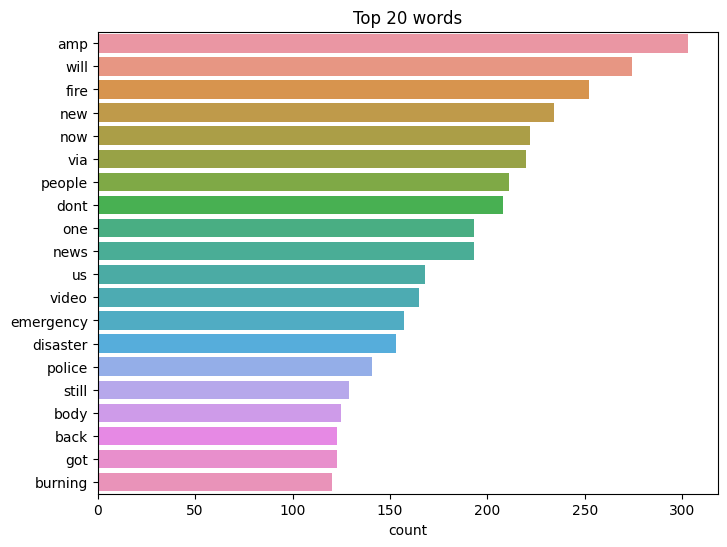

In [24]:
# Unigrams
word_freq = FreqDist(w for w in word_tokenize(' '.join(train['text']).lower()) if (w not in stopwords) & (w.isalpha()))

df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=top20w['count'], y=top20w.index)
plt.title("Top 20 words")
plt.show()

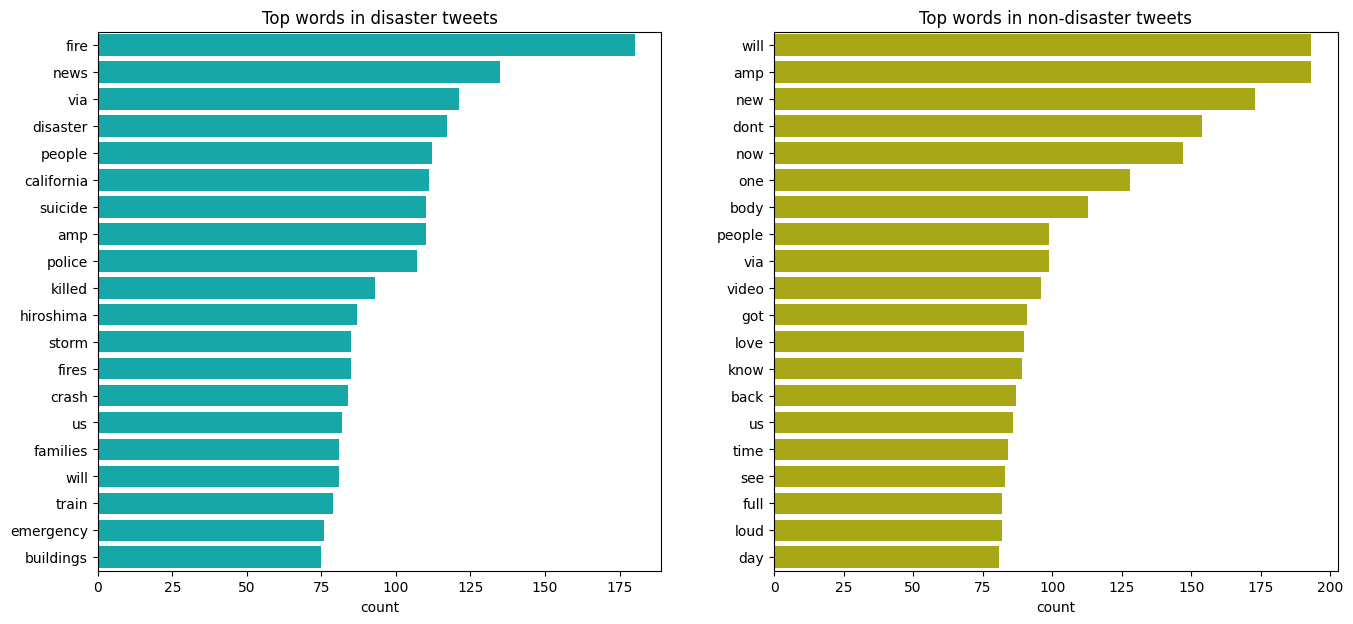

In [25]:
plt.figure(figsize=(16,7))
plt.subplot(121)
freq_d = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_d = pd.DataFrame.from_dict(freq_d, orient='index', columns=['count'])
top20_d = df_d.sort_values('count',ascending=False).head(20)
sns.barplot(x=top20_d['count'], y=top20_d.index, color='c')
plt.title('Top words in disaster tweets')
plt.subplot(122)
freq_nd = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_nd = pd.DataFrame.from_dict(freq_nd, orient='index', columns=['count'])
top20_nd = df_nd.sort_values('count',ascending=False).head(20)
sns.barplot(x=top20_nd['count'],y=top20_nd.index, color='y')
plt.title('Top words in non-disaster tweets')
plt.show()

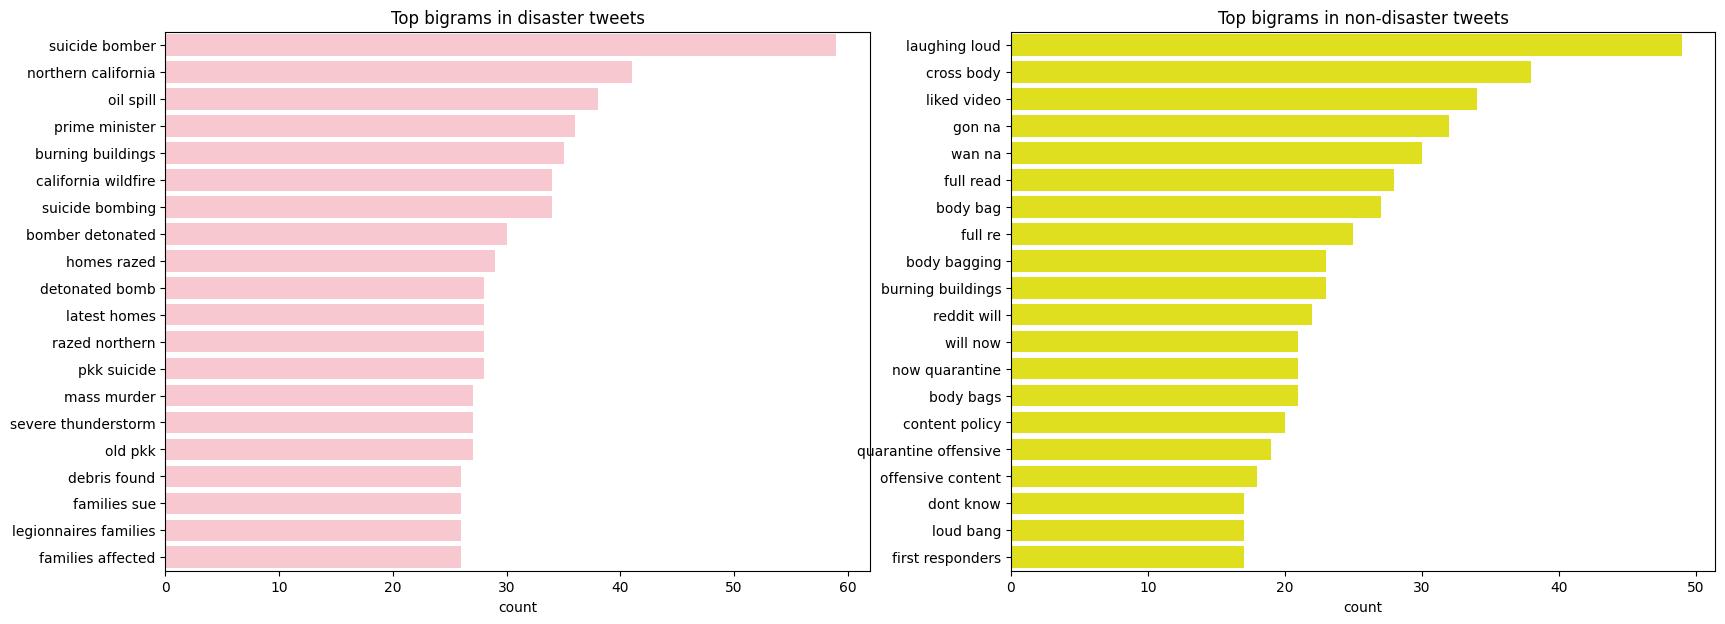

In [26]:
# Bigrams

from nltk import bigrams

plt.figure(figsize=(20,7))
plt.subplot(121)
bigram_d = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
d_fq = FreqDist(bg for bg in bigram_d)
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(x=bgdf_d.head(20)['count'], y=bgdf_d.index[:20], color='pink')
plt.title('Top bigrams in disaster tweets')
plt.subplot(122)
bigram_nd = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
nd_fq = FreqDist(bg for bg in bigram_nd)
bgdf_nd = pd.DataFrame.from_dict(nd_fq, orient='index', columns=['count'])
bgdf_nd.index = bgdf_nd.index.map(lambda x: ' '.join(x))
bgdf_nd = bgdf_nd.sort_values('count',ascending=False)
sns.barplot(x=bgdf_nd.head(20)['count'], y=bgdf_nd.index[:20], color='yellow')
plt.title('Top bigrams in non-disaster tweets')
plt.show()

In [37]:
def custom_standardization(input_data):


  return tf.strings.regex_replace(input_data,'[%s]' % re.escape(string.punctuation),'')

In [28]:
# def custom_standardization(input_data):
#   lowercase = tf.strings.lower(input_data)
#   #removing HTML
#   stripped_html = tf.strings.regex_replace(lowercase, '', '')
#   # print("After Sttripping = + " + stripped_html[0])

#   #removing hyperlink
#   stripped_hyperlink = tf.strings.regex_replace(stripped_html,'https?://\S+|www\.\S+', '')
#   # print("After Sttripping hyperlink= + " + stripped_hyperlink[0])

#   #removing square brackets  
#   stripped_square_brackets = tf.strings.regex_replace(stripped_hyperlink,'.*?', '')
#   # print("After Sttripping square brackets= + " + stripped_square_brackets[0])

#   #removing puncuation
#   stripped_puncuation = tf.strings.regex_replace(stripped_square_brackets,'[%s]' % re.escape(string.punctuation), '')
#   stripped_puncuation = tf.strings.regex_replace(stripped_puncuation ,'\n' , '')
#   # print("After Sttripping punctuation= + " + stripped_puncuation[0])

#   #remove words containing numbers
#   stripped_number = tf.strings.regex_replace(stripped_puncuation ,'\w*\d\w*' , '')
#   # print("After Sttripping numbers= + " + stripped_number[0])


#   return tf.strings.regex_replace(stripped_number,'[%s]' % re.escape(string.punctuation),'')

In [7]:
# print(train['text'].head())
train['text'] = custom_standardization(train['text'])
# print(train['text'].head())

In [38]:
max_features = 10000 # no of word in vocab
sequence_length = 250

### 5. TextVectorization

In [39]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [40]:
train['text'].values

array(['our deeds are the reason of this earthquake may allah forgive us all',
       'forest fire near la ronge sask canada',
       'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
       ..., '  utc s of volcano hawaii',
       'police investigating after an ebike collided with a car in little portugal ebike rider suffered serious nonlife threatening injuries',
       'the latest more homes razed by northern california wildfire  abc news'],
      dtype=object)

In [41]:
vectorize_layer.adapt(train['text'].values)

In [42]:
vectorize_text = vectorize_layer(train['text'].values)
vectorize_text

<tf.Tensor: shape=(7613, 250), dtype=int64, numpy=
array([[ 107, 5808,   22, ...,    0,    0,    0],
       [ 176,   43,  216, ...,    0,    0,    0],
       [  39, 1689, 1516, ...,    0,    0,    0],
       ...,
       [1832,  148,    6, ...,    0,    0,    0],
       [  75, 1075,   40, ...,    0,    0,    0],
       [   2,  194,   53, ...,    0,    0,    0]], dtype=int64)>

In [43]:
X = vectorize_text
y = train['target']

### 6. Defining model

In [58]:
embedding_dim = 32

model = Sequential([
    Embedding(max_features + 1, embedding_dim),
    Bidirectional(LSTM(32, activation='tanh')),

    Dense(64,activation='relu'),
    Dropout(0.2),

    Dense(128,activation='relu'),
    Dropout(0.2),

    Dense(64,activation='relu'),
    Dropout(0.2),

    Dropout(0.2),
    Dense(1,activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320032    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [60]:
history = model.fit(X,y,epochs=10)

Epoch 1/10
238/238 [==============================] - 25s 86ms/step - loss: 0.5551 - accuracy: 0.7171
Epoch 2/10
238/238 [==============================] - 21s 87ms/step - loss: 0.3493 - accuracy: 0.8560
Epoch 3/10
238/238 [==============================] - 21s 88ms/step - loss: 0.2458 - accuracy: 0.9057
Epoch 4/10
238/238 [==============================] - 21s 88ms/step - loss: 0.1666 - accuracy: 0.9414
Epoch 5/10
238/238 [==============================] - 21s 89ms/step - loss: 0.1233 - accuracy: 0.9568
Epoch 6/10
238/238 [==============================] - 22s 92ms/step - loss: 0.0917 - accuracy: 0.9660
Epoch 7/10
238/238 [==============================] - 23s 95ms/step - loss: 0.0776 - accuracy: 0.9658
Epoch 8/10
238/238 [==============================] - 22s 92ms/step - loss: 0.0675 - accuracy: 0.9693
Epoch 9/10
238/238 [==============================] - 22s 92ms/step - loss: 0.0573 - accuracy: 0.9719
Epoch 10/10
238/238 [==============================] - 22s 93ms/step - loss: 0.057

### 7. Checking accuracy

In [61]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

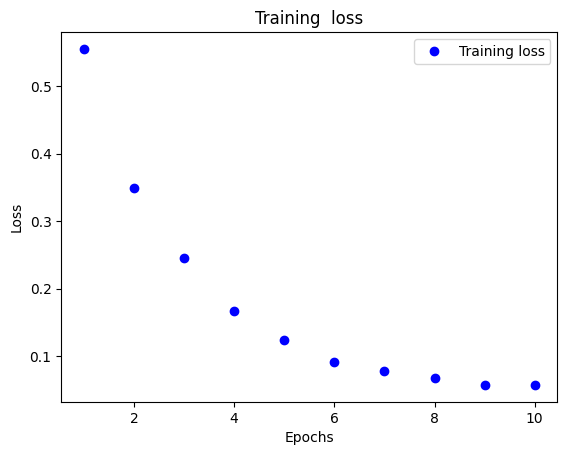

In [62]:
acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.title('Training  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
     

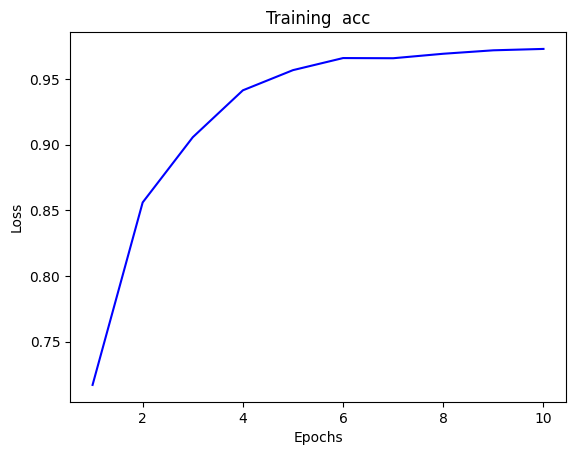

In [63]:
plt.title('Training  acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, acc, 'b', label='Validation loss')

### 8. Testing

In [44]:
test['text'] = custom_standardization(test['text'])

In [37]:
import random

random_num = random.randint(0,(3263-1))

data = test['text'][random_num]

# data = 'our deeds are the reason of this earthquake may allah forgive us all'
# # data = "what's up"

input_data = vectorize_layer(data)
# print(input_data)

predictions = model.predict(np.expand_dims(input_data,0))

print(data)
print(predictions)

NameError: name 'model' is not defined

In [67]:
value = predictions[0][0]
value > 0.5

True

In [68]:
if value>0.5 or value == 0.5 :
  print('Disaster Tweets')
elif value < 0.5:
  print('Not a Disaster Tweets')

Disaster Tweets


In [21]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("text_classifier.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("text_classifier.h5")
print("Saved model to disk")

NameError: name 'model' is not defined

In [45]:
# load json and create model
from keras.models import model_from_json
json_file = open('text_classifier.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("text_classifier.h5")
print("Loaded model from disk")

Loaded model from disk


In [46]:
loaded_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [51]:
import random

random_num = random.randint(0,(3263-1))

data = test['text'][random_num]
# data = 'our deeds are the reason of this earthquake may allah forgive us all'
# # data = "what's up"

input_data = vectorize_layer(data)

predictions = loaded_model.predict(np.expand_dims(input_data,0))

print(data)
print(predictions)

1/1 [==============================] - 0s 53ms/step
b'chattanooga the latest california governor headed to site of wildfire'
[[0.9999737]]


In [52]:
value = predictions[0][0]
value > 0.5

True

In [53]:
if value>0.5 or value == 0.5 :
  print('Disaster Tweet')
elif value < 0.5:
  print('Not a Disaster Tweet')

Disaster Tweet
